# CEO RECOMMENDATIONS

***CEO Question***

*How do we increase customer satisfaction (so as to increase profit margins) while maintaining a healthy order volume?*

**Findings from our Preliminary Analysis of the Orders and Sellers Datasets**

- The *more* sellers (`number_of_sellers`) and products (`number_of_products`) that are combined into a single order, the *lower* the review score.  
- The *longer* the `wait_time` for a delivery, the *lower* the review score.  

Our earlier analysis also found that *orders containing multiple sellers or products do not make up a large portion of orders on the platform* (~10%), so any policy changes (e.g. restricting orders to a single seller) would have a limited impact. 

Additionally, `wait_time` is made up of two components (seller's `delay_to_carrier` + `carrier_delivery_time`). Our analysis also found that the proportion of sellers who have delayed shipment to a carrier is only about 6%. Moreover, the component `carrier_delivery_time` is less directly in Olist's control and further analysis of their operations or finding new carrier partners is not an easy-fix we'd like to propose to the CEO. 

It appears that there are other factors contributing to a low review score that are outside of the Orders and Sellers datasets. Rather than searching for and trying to isolate all the factors contributing to low review scores, we'll try a different approach in this notebook.

Since our preliminary analysis suggests there are multiple factors driving low review scores, and focusing efforts on improving a single factor may not be sufficient, let's instead use low review scores as a way to filter better performing sellers. By ascribing costs associated with low review scores, we'll also be able to calculate how much impact keeping these sellers on the platform have on the bottom line.    
 

**Notebook Objective**

In this notebook, we'll **identify poor-performing sellers, quantify their impact on Olist's profit margins, and make specific recommendations to the CEO on what short-term changes can be made to increase customer satisfaction and Olist's bottom line.**


**Next Steps in our Analysis**
1. Calculate how much revenue each seller brings in to Olist
2. Calculate the cost to Olist from bad reviews for each seller
3. Calculate the profit to Olist for each seller 
3. Understand the impact on Olist's profits from poor-performing sellers
4. Find out how much removing these sellers would impact Olist's IT costs 

In [3]:
import os
os.sys.path


['/Users/atat/code/phlln/olist-analysis/notebooks',
 '/Users/atat/code/phlln/data-challenges/04-Decision-Science',
 '/Users/atat/code/phlln/olist-analysis/notebooks',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python38.zip',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python3.8',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python3.8/lib-dynload',
 '',
 '/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages',
 '/Users/atat/code/phlln/mlproject',
 '/Users/atat/code/phlln/TFM_TrainAtScale',
 '/Users/atat/code/phlln/TFM_PredictInProd',
 '/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/extensions',
 '/Users/atat/.ipython']

In [4]:
os.sys.path.insert(0, '/Users/atat/code/phlln/olist-analysis/' )
os.sys.path

['/Users/atat/code/phlln/olist-analysis/',
 '/Users/atat/code/phlln/olist-analysis/notebooks',
 '/Users/atat/code/phlln/data-challenges/04-Decision-Science',
 '/Users/atat/code/phlln/olist-analysis/notebooks',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python38.zip',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python3.8',
 '/Users/atat/.pyenv/versions/3.8.6/lib/python3.8/lib-dynload',
 '',
 '/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages',
 '/Users/atat/code/phlln/mlproject',
 '/Users/atat/code/phlln/TFM_TrainAtScale',
 '/Users/atat/code/phlln/TFM_PredictInProd',
 '/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/extensions',
 '/Users/atat/.ipython']

In [5]:
# Import typical libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from olist.seller import Seller
from olist.data import Olist 

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# #CAN BE DELETED LATER
# #export dataset for Tableau
# path = '../data/csv/seller_dataset_modified.csv'
# sellers.to_csv(path_or_buf=path, index=False)

In [7]:
data = Olist().get_data()
data

{'sellers':                              seller_id  seller_zip_code_prefix  \
 0     3442f8959a84dea7ee197c632cb2df15                   13023   
 1     d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
 2     ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
 3     c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
 4     51a04a8a6bdcb23deccc82b0b80742cf                   12914   
 ...                                ...                     ...   
 3090  98dddbc4601dd4443ca174359b237166                   87111   
 3091  f8201cab383e484733266d1906e2fdfa                   88137   
 3092  74871d19219c7d518d0090283e03c137                    4650   
 3093  e603cf3fec55f8697c9059638d6c8eb5                   96080   
 3094  9e25199f6ef7e7c347120ff175652c3b                   12051   
 
             seller_city seller_state  
 0              campinas           SP  
 1            mogi guacu           SP  
 2        rio de janeiro           RJ  
 3             sao paul

In [9]:
# Load Sellers data
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99


## Revenue per seller

Olist generates revenue from its sellers through two components:
1. **Monthly Membership Fee**: sellers pay Olist an **80 Brazilian Real (BRL)** (~15 USD) monthly fee to use the platform
2. **Revenue Share**: for every order on the platform, Olist takes a **10% cut** based on the product price  of each item (excl. shipping)


In [10]:
# Revenue Calculation: Monthly Membership Fee Calculation + Revenue Share

# Calculate total time on platform (in months)
number_of_months_on_olist = (sellers.date_last_sale - sellers.date_first_sale) / np.timedelta64(1, 'M')
sellers['months_on_olist'] = number_of_months_on_olist.map(lambda x: 1 if x < 1 else np.ceil(x))

# Calculate total revenue each seller has generatedb for Olist
sellers['revenue_per_seller'] = sellers.months_on_olist * 80 + sellers.sales * 0.1
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales,revenue_per_seller
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,15.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2370.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,1.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,1.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,96.799


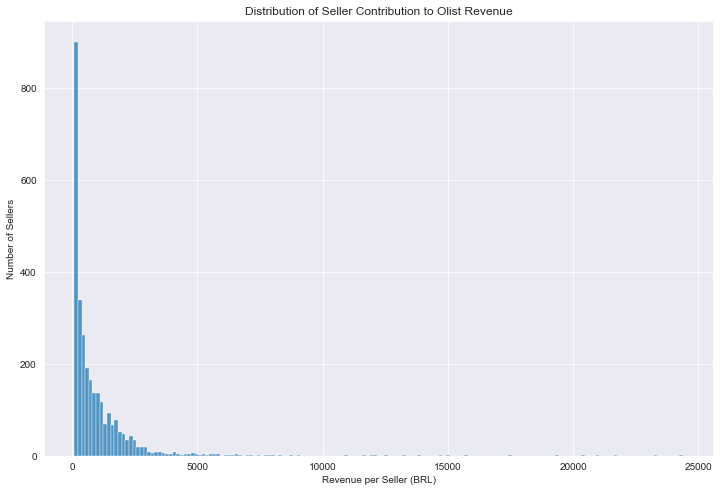

In [11]:
# Plot histogram of seller revenue
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')

ax = sns.histplot(sellers.revenue_per_seller)
ax.set_xlabel('Revenue per Seller (BRL)')
ax.set_ylabel('Number of Sellers')
ax.set_title('Distribution of Seller Contribution to Olist Revenue');

In [12]:
sellers[['revenue_per_seller']].describe()

,revenue_per_seller
count,2970.000000
mean,986.186944
std,1655.679175
min,80.650000
25%,173.099250
50%,504.049000
75%,1223.955000
max,24387.263000


Half of all sellers on the platform have brought in less than **504 BRL** (95 USD). 

## Cost per seller

Because poor reviews from customers can have several direct and indirect costs to a business (e.g. customer support utilization, bad word-of-mouth, low repeat rate, etc.), we'll use the following table to estimate monetary costs associated with bad reviews:

**Estimated cost to Olist per bad review (in BRL)** (100 BRL $\approx$ 20 USD)
- **1 star:** 100
- **2 stars:** 50
- **3 stars:** 40
- **4 stars:** 0
- **5 stars:** 0

In [13]:
sellers[['seller_id','seller_review_score','review_cost_per_seller']].head()

,seller_id,seller_review_score,review_cost_per_seller
0,3442f8959a84dea7ee197c632cb2df15,3.00,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,4.55,240
2,ce3ad9de960102d0677a81f5d0bb7b2d,5.00,0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,5.00,0
4,51a04a8a6bdcb23deccc82b0b80742cf,1.00,100


- `seller_review_score`: the average review score earned by a seller.

- `review_cost_per_seller`: the total cost from all bad reviews for each seller. It's calculated by first assigning a monetary cost for any review *receiving 3 stars or less*, and then these costs are totaled up per seller. 

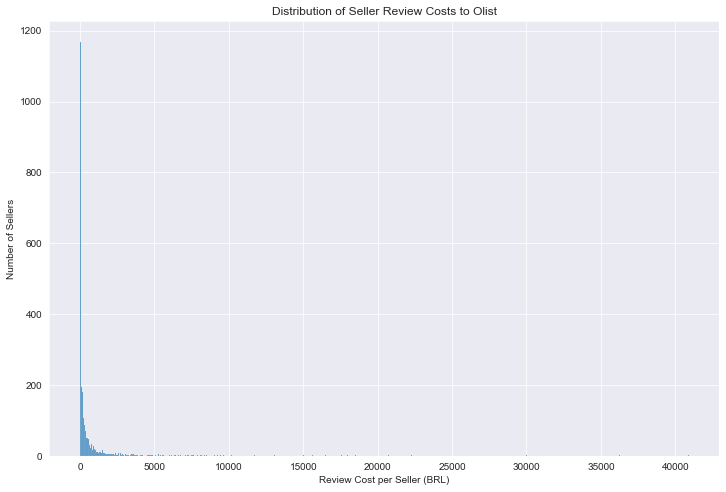

In [15]:
# Plot histogram of seller revenue
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')

ax = sns.histplot(sellers.review_cost_per_seller)
ax.set_xlabel('Review Cost per Seller (BRL)')
ax.set_ylabel('Number of Sellers')
ax.set_title('Distribution of Seller Review Costs to Olist');

In [16]:
sellers[['review_cost_per_seller']].describe()

,review_cost_per_seller
count,2970.000000
mean,562.131313
std,1941.000427
min,0.000000
25%,0.000000
50%,100.000000
75%,380.000000
max,40890.000000


In [19]:
# Percentage of sellers who have some bad reviews (3 stars or less)
(sellers[sellers.review_cost_per_seller > 0]['review_cost_per_seller'].count() / len(sellers) ) * 100

70.16835016835017

While **70%** of sellers have had **at least 1 bad review** (3 stars or less), we can see that **most sellers do not have enough bad reviews to cost Olist substantially**, since even at the **75th percentile**, *total review costs* per seller are below **380 BRL** (~70 USD). This along with our distribution plot suggest that it's a small number of sellers that bring about a disproportionate number of bad reviews which ultimately cost Olist.

However, to get a clearer picture of the impact, we should include revenues and actually calculate the *profit per seller.* 

## Profit per seller 

Now that we know how much revenue each seller generates for Olist and also the cost of bad reviews, let's calculate the profit to Olist from each seller. This will allow us to see more clearly *which sellers* are a drag on Olist's bottom line and *by how much.* 

We've also been asked by the CEO to consider the IT costs associated with running the platform, but for now we'll set that aside in our analysis and examine it later.   

In [21]:
# Calculate the profit as 'revenue_per_seller' - 'review_cost_per_seller'
sellers['profit_per_seller'] = sellers.revenue_per_seller - sellers.review_cost_per_seller
sellers[['seller_id', 'revenue_per_seller', 'review_cost_per_seller', 'profit_per_seller']].groupby(by='seller_id').sum()

sellers[['seller_id', 'revenue_per_seller', 'review_cost_per_seller', 'profit_per_seller']].head()

,seller_id,revenue_per_seller,review_cost_per_seller,profit_per_seller
0,3442f8959a84dea7ee197c632cb2df15,341.870,140,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,2370.307,240,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,95.800,0,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,87.999,0,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,96.799,100,-3.201


Let's take a quick look at the distribution of `profit_per_seller`.

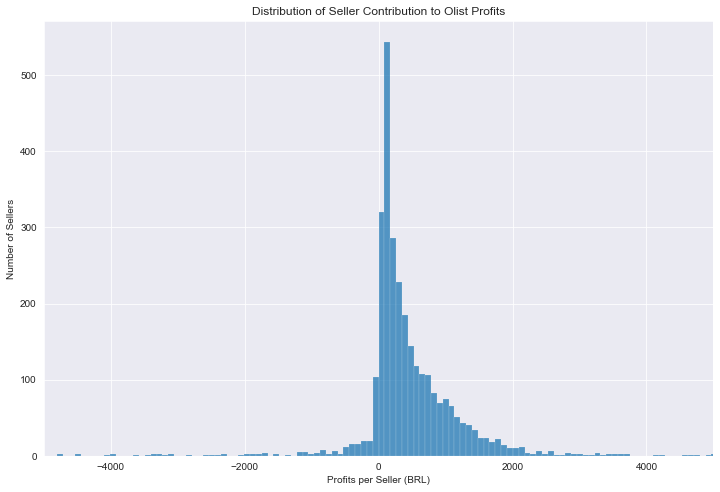

In [22]:
# Plot histogram of 'profit_per_seller'
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')

ax = sns.histplot(sellers.profit_per_seller)
ax.set_xlim(xmin=-5000, xmax=5000)
ax.set_xlabel('Profits per Seller (BRL)')
ax.set_ylabel('Number of Sellers')
ax.set_title('Distribution of Seller Contribution to Olist Profits');

In [23]:
# Summary stats
sellers.profit_per_seller.describe()

count     2970.000000
mean       424.055631
std       1274.295160
min     -22419.517000
25%         93.000000
50%        285.790500
75%        720.593750
max      17967.605000
Name: profit_per_seller, dtype: float64

From our histogram and summary stats, it appears the **middle 50% of sellers** on the platform generate anywhere from **93 to 721 BRL** (~17 to 134 USD) for Olist. We can also see from the distribution plot a number of sellers with negative impact on profits. 
 
Let's see if we can find out more about these poor-performing sellers who are pulling down Olist profits. 

## Understanding the Impact of Poor-performing Sellers

To get a clearer picture of how much impact these poor-performing sellers have on Olist's profits, we'll break this question down into smaller parts:

1. **How many** poor-performing sellers (those who have a negative impact on profits) are on the platform?
2. **How much in total** do these poor-performing sellers affect Olist profits? 

### How many sellers are negatively impacting Olist profits?

Let's find the total number of poor-performing sellers, and also see what proportion they make on the platform. 

In [24]:
# Simple function to create column indicating whether sellers have positive or negative impact on profits
def olist_impact(x):
    if x < 0:
        return 'negative'
    else:
        return 'positive'

sellers['impact'] = sellers['profit_per_seller'].apply(olist_impact)
sellers[['impact','seller_id']].groupby('impact').count()

,seller_id
impact,
negative,276
positive,2694


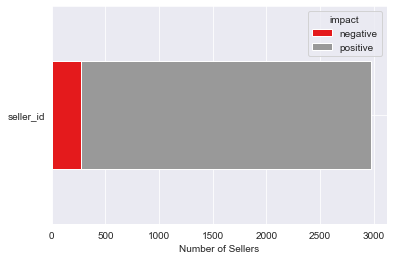

In [26]:
# Bar plot to visualize the proportion of poor-performing sellers
sellers[['impact','seller_id']].groupby('impact').count().transpose().plot.barh(stacked=True, cmap='Set1')
plt.xlabel('Number of Sellers');

In [27]:
# Proportion of poor-performing sellers
sellers[['impact']].value_counts(normalize=True)

impact  
positive    0.907071
negative    0.092929
dtype: float64

We can now see that there are **276 sellers** (or **roughly 9%** of all sellers) who **negatively impact** Olist profits, and that we'll classify as **poor-performing**.

### How much in total do poor-performing sellers impact Olist profits?

To get a better picture of how much impact these sellers have on Olist's total profits, let's create a **whale curve** which will show us *what percentage* of sellers represent *what percentage* of cumulative profits. 



### Whale Curve

To build our whale curve, we'll first sort our sellers from *most to least profitable*. Then we'll plot the *cumulative profits* from each additional seller to the platform.   

In [28]:
# Sort sellers by how much profit each contributes to Olist (from most to least)
sellers.sort_values('profit_per_seller', ignore_index=True, inplace=True, ascending=False)

# Calculate cumulative profits to Olist with each additional seller
sellers['cumulative_profits'] = sellers['profit_per_seller'].cumsum()
sellers.tail()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales,revenue_per_seller,profit_per_seller,impact,cumulative_profits
2965,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118770,0.567338,4.069989,15620,943,1018,1.079533,17535.69,2553.569,-13066.431,negative,1335110.855
2966,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,13.0,0.116827,0.524847,3.984307,20710,1146,1204,1.050611,37177.52,4757.752,-15952.248,negative,1319158.607
2967,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.117277,0.581808,4.069222,30000,1706,1819,1.066237,104288.42,11948.842,-18051.158,negative,1301107.449
2968,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.147640,0.476948,3.804610,40890,1806,2009,1.112403,200472.92,21647.292,-19242.708,negative,1281864.741
2969,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,19.0,0.127957,0.510215,3.922043,36270,1854,2039,1.099784,123304.83,13850.483,-22419.517,negative,1259445.224


In [29]:
# Total cumulative profits for Olist
total_profits = sellers['cumulative_profits'].iloc[-1]
total_profits

1259445.2239999846

In [30]:
# Calculate the cumulative percentage of profits represented by each additional seller
sellers['percent_profits'] = sellers['cumulative_profits'].div(total_profits).mul(100)

# Calculate the proportion of sellers represented (in percent)
sellers['seller_proportion'] = (sellers.index+1) / sellers.seller_id.count() * 100

whale_df = sellers[['seller_id', 'percent_profits', 'seller_proportion']]
whale_df.tail()

,seller_id,percent_profits,seller_proportion
2965,8b321bb669392f5163d04c59e235e066,106.007854,99.86532
2966,ea8482cd71df3c1969d7b9473ff13abc,104.741245,99.89899
2967,cc419e0650a3c5ba77189a1882b7556a,103.307982,99.93266
2968,4a3ca9315b744ce9f8e9374361493884,101.780111,99.96633
2969,6560211a19b47992c3666cc44a7e94c0,100.000000,100.00000


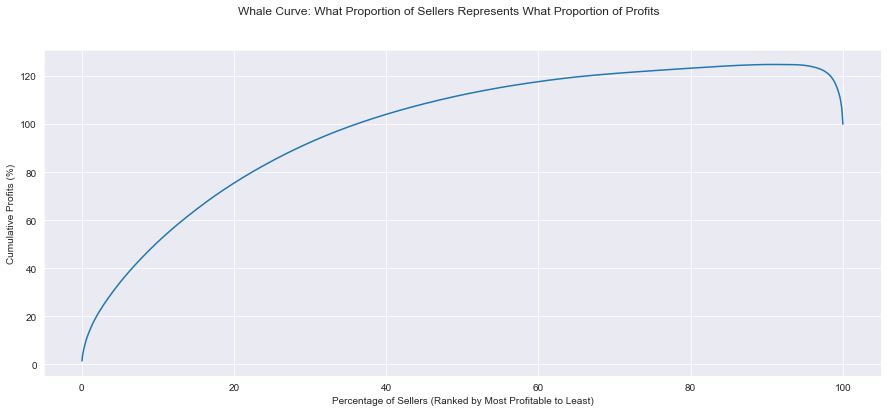

In [60]:
# Build our whale curve
plt.figure(figsize=(15,6))
plt.suptitle('Whale Curve: What Proportion of Sellers Represents What Proportion of Profits')
sns.lineplot(data=sellers, x='seller_proportion', y='percent_profits')
plt.xlabel('Percentage of Sellers (Ranked by Most Profitable to Least)')
plt.ylabel('Cumulative Profits (%)');

Our whale curve helps to underscore that **roughly 80%** of our sellers **contribute to 120% of Olist profits**. Another **10%** of sellers have a **negligible impact**. And, the **remaining 10%** drag down profits by **20%**.  

### Profits without the Poor-performing Sellers

Let's visualize this another way. What would Olist profits be if poor-performing sellers were no longer on the platform.

In [40]:
# Amount of reduction in profits due to bad reviews
neg_profits = sellers[sellers['impact']=='negative'].profit_per_seller.cumsum()
neg_profits.iloc[-1]

-313276.50200000097

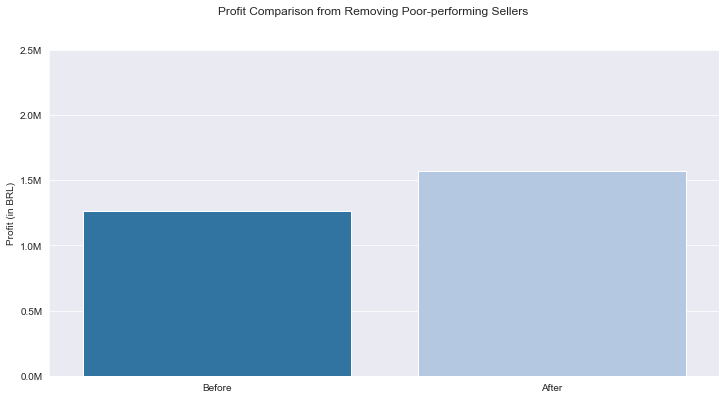

In [44]:
# Bar chart showing profit comparison after removal of poor-performing sellers
fig = plt.figure(figsize=(12,6))
x_values = ['Before', 'After']
y_values = [sellers.cumulative_profits.iloc[-1], sellers.cumulative_profits.iloc[-1] - neg_profits.iloc[-1]]
ax = sns.barplot(data=sellers, x=x_values, y=y_values, palette='tab20')

plt.ylabel('Profit (in BRL)')
plt.ylim(0, 2500000)
plt.suptitle('Profit Comparison from Removing Poor-performing Sellers', fontsize=12)
ax.set_yticks(ax.get_yticks())
yticklabels=['{:3.1f}'.format(y) + 'M' for y in ax.get_yticks()/1000000]
ax.set_yticklabels(yticklabels);

If Olist were to **drop sellers who had a negative impact on profits**, the platform would see an **immediate boost in profits** of **313,277 BRL** (58,246 USD)! 

## What's the impact if we factor in IT costs?

While it does appear that Olist's profit margins would benefit from removing poor-performing sellers, we've been asked to examine how removal of these sellers might also impact Olist's IT costs (servers, etc.). 

Olist's IT costs increase with the number of orders processed, but does so less and less rapidly due to scale effects. More precisely, we've been told that **IT costs are proportional to the square-root of cumulative number of orders**. Additionally, the IT department has reported accumulated IT costs of **500,000 BRL** (~92,930 USD) since the founding of the company.

Let's approach this with the following steps: 

1. Calculate the amount of IT costs for any given order volume. 
2. Compute the order volume for each group
3. Find the average order volume per seller for each group
2. Calculate the order volume of poor-performing sellers and the accompanying IT costs. 
3. Compare the difference in IT costs after removing poor-performing sellers.

### What are the IT costs for a particular order volume?

We've been provided information that IT costs are *proportional to the square-root of the number of approved orders*:

**Olist IT costs = $k\sqrt{n}$**

Here ***n*** is the ***total number of approved orders*** and ***k*** is a ***proportionality constant***.

Given this IT cost curve, we can see that it should take on the shape of a concave ascending curve like $ y = \sqrt{x} $ but also transformed by a proportionality constant *k*. Let's plot a generic $ y = \sqrt{x} $ to help visualize the overall shape of the curve.

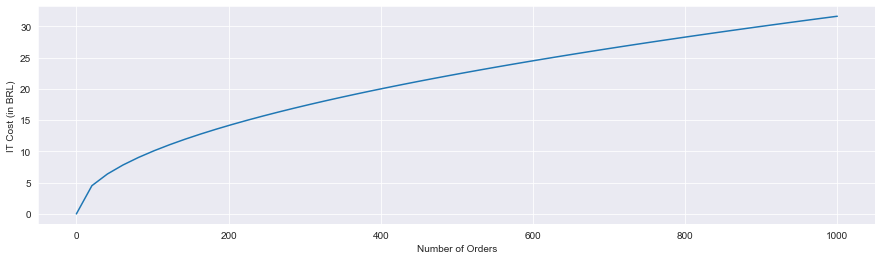

In [46]:
# Plot a generic y = x**(1/2) curve

plt.figure(figsize=(15,4))
x=np.linspace(0,1000, 50)
y=x**0.5
sns.lineplot(x=x, y=y)
plt.xlabel('Number of Orders')
plt.ylabel('IT Cost (in BRL)');

Given the shape of this particular cost curve, we can already see that IT costs will steadily increase with more orders. However, the difference in IT cost between each additional order (marginal IT cost) is the greatest early on (when order numbers are low). At higher order volume, the IT cost appears to change less and less rapidly. 

Let's now try to get a more precise curve by doing a little math to solve for the proportionality constant *k*. 

Since we've been told that the cumulative cost of IT to date is **500,000 BRL**, we can set this equal to the area under the curve bounded by 0 to the *current number of orders* ***n***.

Then to calculate the proportionality constant *k*, we just need to take the definite integral of this expression.



$\int_{0}^{n} k\sqrt{n}$ = 500,000    

where *n* is the number of orders and *k* is a proportionality constant

In [47]:
# Total of n_orders
total_orders = sellers.n_orders.sum()
total_orders

99844

Let's evaluate the integral from **0** orders to the total cumulative number of orders **99,844**. 

**$\int_{0}^{n} k\sqrt{n} \to \int_{0}^{99,844} k(\frac{2}{3}) n^\frac{3}{2} - k(\frac{2}{3}) (0)^\frac{3}{2} $**

Setting this equal to 500,000, we can solve for the proportionality constant ***k***.

**$ k(\frac{2}{3}) (99,844)^\frac{3}{2} = 500,000 $**

In [48]:
# Evaluate integral and solve for proportionality constant k
k = 500000 / ((2/3)*(99844**1.5))
k

0.023772688842554592

This gives us the proportionality constant **k** $\approx$ **0.024**. Now let's re-plot our IT cost curve more precisely.

$ y = \hspace{0.25 cm} k \sqrt{n}  \hspace{0.25 cm} = 0.024\sqrt{n} $

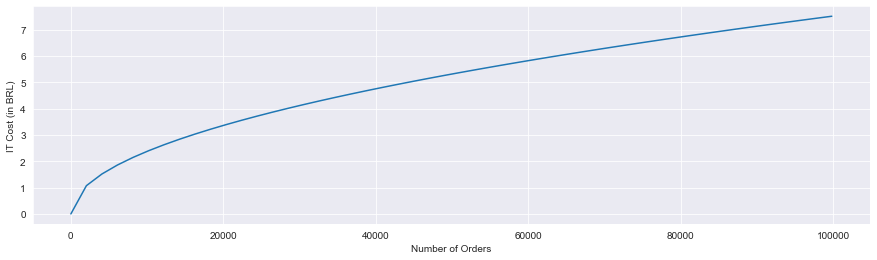

In [49]:
# Re-plot our IT cost curve with our calculated proportionality constant k

plt.figure(figsize=(15,4))
x=np.linspace(0,99844, 50)
y=(k)*(x**0.5)
sns.lineplot(x=x, y=y)
plt.xlabel('Number of Orders')
plt.ylabel('IT Cost (in BRL)');

We can now see what the IT cost will be at a particular order volume. The slope of the curve starts to stabilize once you approach 20,000 orders telling us that benefits from scale effects will start to matter less for IT costs. As the IT costs becomes more linear in shape, it means that more orders will just increase IT costs at a constant rate. 

Let's now examine the IT costs associated with specific sellers. Since IT costs are a function of order volume, we'll also see if there are differences between our good and poor-performing sellers.  

### Order Volume

Since IT costs are driven by order volume, let's see if there is a difference for these two groups of sellers.

In [58]:
# Calculate the order volume for each group of sellers
order_vol_df = sellers[['n_orders','impact']].groupby('impact').sum().transpose()
order_vol_df

impact,negative,positive
n_orders,39817,60027


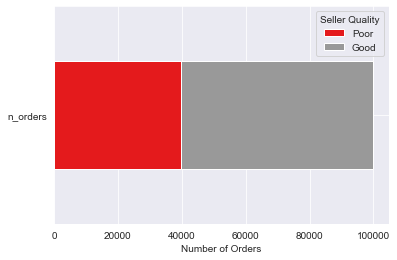

In [64]:
# Bar plot to see composition of order volume by quality of seller
order_vol_df.plot.barh(stacked=True, cmap='Set1')
plt.legend(title='Seller Quality', labels=['Poor', 'Good'])
plt.xlabel('Number of Orders');

We now see that **poor-performing sellers** have about **40%** of the *order volume* on Olist but make up only **9%** of all sellers on the platform. This tells us that they are contributing to a **larger share of the IT cost burden** for Olist.

### Average Order Volume by Seller Quality

For another perspective on the difference in order volume with these two groups, let's calculate the average order volume per seller for each group and compare. 

In [66]:
# Calculate the average order volume per seller for each group of sellers
avg_order_vol = sellers[['n_orders','impact']].groupby('impact').mean().transpose()
avg_order_vol

impact,negative,positive
n_orders,144.264493,22.281737


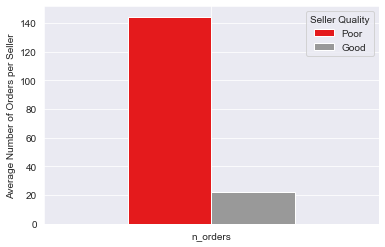

In [73]:
avg_order_vol.plot(kind='bar', cmap='Set1', ylabel='Average Number of Orders per Seller', rot=0, legend=True)
plt.legend(title='Seller Quality', labels=['Poor', 'Good']);

We can see that **poor-performing sellers** have an *average order volume* of roughly **7x** more than other sellers. This underscores their **heavy usage of the IT infrastructure and extra IT cost burden.**

### IT Costs Associated with Specific Sellers

In [51]:
# Calculate IT costs per additional seller on the platform 

# The cumulative total of orders on the platform after adding the seller
sellers['cumulative_orders'] = sellers['n_orders'].cumsum()

# The cumulative total IT cost for Olist after adding the seller
sellers['cumulative_it_cost'] = k*(2/3)*(sellers['cumulative_orders']**1.5)

sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,quantity_per_order,sales,revenue_per_seller,profit_per_seller,impact,cumulative_profits,percent_profits,seller_proportion,cumulative_orders,cumulative_it_cost
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,0.097765,0.558659,...,1.145251,222776.05,23237.605,17967.605,positive,17967.605,1.426629,0.03367,358,107.352358
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,22.0,0.104167,0.627976,...,1.011905,176431.87,19403.187,14603.187,positive,32570.792,2.586122,0.06734,694,289.751873
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,0.088889,0.673504,...,1.001709,194042.03,21004.203,14254.203,positive,46824.995,3.717906,0.10101,1279,724.924643
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.0,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,0.066265,0.692771,...,1.054217,79284.55,8808.455,7288.455,positive,54113.450,4.296610,0.13468,1445,870.540173
4,ccc4bbb5f32a6ab2b7066a4130f114e3,curitiba,PR,0.0,15.853247,2017-01-07 14:00:13,2018-08-21 21:05:16,20.0,0.085561,0.652406,...,1.026738,74004.62,9000.462,6780.462,positive,60893.912,4.834979,0.16835,1632,1044.882074


Let's now see what the total and average IT cost would be for Olist if poor-performing sellers were to be removed.



In [ ]:
# Total Cumulative IT Cost with poor performers removed
it_cost_post_removal = 0.024*(2/3)*((60028)**1.5)
it_cost_post_removal

In [ ]:
# Average IT cost per order with poor performers removed
it_cost_post_removal / order_vol_df.iloc[1]

Let's now compare both total and average IT costs if we were to remove poor-performing sellers from the platform.



In [ ]:
total_it_cost = sellers[['impact', 'cumulative_it_cost']].groupby('impact').max().transpose()
total_it_cost

In [ ]:
# Total Cumulative IT Costs before and after removing poor performers

fig = plt.figure(figsize=(12,6))
x_values = ['Before', 'After']
y_values = [total_it_cost.iloc[0,0], total_it_cost.iloc[0,1]]
ax = sns.barplot(data=sellers, x=x_values, y=y_values, palette='tab20')

plt.ylabel('IT Cost (in BRL)')
plt.ylim(0, 600000)
plt.suptitle('IT Cost Comparison from Removing Poor-performing Sellers', fontsize=12)
ax.set_yticks(ax.get_yticks())
yticklabels=['{:3.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]
ax.set_yticklabels(yticklabels);

In [ ]:
# Calculation of reduction of total IT costs from removing poor-performing sellers
total_it_cost.iloc[0,0] - total_it_cost.iloc[0,1]

Removing poor-performing sellers from the platform reduces order volume by 40% and translates into a reduction of **266,919 BRL** (~50,868 USD) in IT costs.

In [ ]:
# Our IT Cost Curve

plt.figure(figsize=(15,4))
x=np.linspace(0,99844, 100)
y=(k)*(x**0.5)
sns.lineplot(x=x, y=y)
plt.xlabel('Number of Orders')
plt.ylabel('IT Cost (in BRL)');

As we can already see from the shape of the IT Cost Curve, the greatest difference in marginal IT cost occurs at very low order volume. 

In [ ]:
# order volume if removed 60,027 

To verify this more precisely, we can return to our IT Cost Curve. The additional cost in IT for each additional order (the marginal IT cost) is essentially the slope of the IT Cost Curve at a specific order volume. 

To arrive at this slope, we can simply take the first derivative of our IT Cost Curve:   
$ f(n) = 0.024\sqrt{n}  \to f\prime(n) = 0.012 (n)^-\frac{1}{2} $

By removing poor-performing sellers from Olist, the order volume would drop from **99,844** to **60,027** orders. However, if we evaluate the marginal IT cost at both of these amounts, we can confirm that the difference in marginal cost is quite small (0.000049 vs. 0.000038). 

Since most of the change in slope for the IT Cost Curve has already already occurred at a lower order volume (more near the range of 10,000 orders), the change in order volume brought about by the removal of poor-performing sellers would have negligible impact on marginal IT Costs. 


In [ ]:
# Calculate the Marginal IT Cost for specific order volume

order_volume = pd.DataFrame(np.arange(1, total_orders+1))

marg_it_cost = 0.012*(order_volume)**-0.5

i_compare =[60027,99843]

marg_it_cost.iloc[i_compare] 



In [ ]:
# Let's find out where marginal IT costs would be the greatest  

order_volume = pd.DataFrame(np.arange(1, total_orders+1))


# Marginal IT Cost
marg_it_cost = 0.012*(order_volume)**-0.5
marg_it_cost.iloc[66027]


In [ ]:
# IT Cost 

it_cost = 0.024*(order_volume)**0.5
it_cost.iloc[66027:66029].diff()


In [ ]:
it_cost.iloc[99842:99844].diff()

In [ ]:
it_cost.iloc[100:130]

In [ ]:
# The average cost of IT per order after adding this seller
#sellers['it_unit_cost'] = sellers.cumulative_it_cost / sellers.cumulative_orders

# The IT cost for Olist after adding this seller
sellers['it_cost'] = k*sellers['cumulative_orders']**0.5

# # Difference between average and marginal IT cost
# sellers['diff_unit_marg_it'] = sellers.it_unit_cost - sellers.it_marg_cost
#sellers['diff_unit_marg_it'].abs().min()

sellers.head()

----NOT SURE WHERE TO PUT YET
Understanding this will help us gauge whether removing the poorest-performing sellers along with their order volume would adversely impact Olist's cost structure. 

Sellers with high order volume also have accompanying higher IT costs associated with them. If poor-performing sellers both pose a drag on profits from the effects of bad reviews, and additionally, with large order volume consume a larger of IT resources, then it becomes even clearer that removal of these sellers would improve profits and relieve the burden on the IT infrastructure.  

**Recommendation to CEO:**

In the short term, we believe that Olist can improve profits and overall customer satisfaction by removing poor-performing sellers.

Our preliminary analysis shows that removing these sellers from the platform will immediately increase Olist profits by reducing costs on two fronts:

1. **Costs Associated with Bad Reviews** - removal of sellers who have received enough bad reviews to have a drag on Olist margins will **boost profits by 20%** amounting to an increase of **313,277 BRL** ($58,246 USD).

2. **IT Costs** - IT costs are a function of overall order volume, and since poor-performing sellers have been found to have a disproportionately large order volume, their removal translates into an overall **40% reduction in IT costs** amounting to a savings of **266,919 BRL** (~50,868 USD). 

In sum, by removing poor-performing sellers from the platform, Olist stands to see an immediate gain of **580,196 BRL** (~110,484 USD) to its financial performance. Additionally, we would expect to see an overall improvement in brand reputation as average customer satisfaction increases.

**Caveats**

These findings have been made based on assumptions for the monetary costs associated with bad reviews as well as the model for IT infrastructure costs.

**Other Areas For Further Analysis**

A more fine-toothed analysis for identifying poor-performing sellers might also review sellers who have only just recently joined the platform and not gained enough experience to properly use the platform properly or engage with customers. With sufficient support, they may potentially become strong performing sellers and advocates for the platform that has a good on-ramping process and support system for new sellers.     

If expanding to a long-term strategy



## Areas to Explore Further

- Evaluate whether can improve average seller performance
- Explore reviews for cause of dissatisfaction